# 介紹

深度學習的世界不僅僅是密集層。我們可以將幾十種層添加到模型中。 （嘗試瀏覽 [Keras 文檔](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) 以獲取範例！）有些類似於密集層並定義神經元之間的連接，有些則可以進行其他類型的預處理或轉換。

在本課中，我們將學習兩種特殊的層，它們本身**不包含任何神經元**，但它們添加了一些有時可以以各種方式使模型受益的功能。兩者都常用於現代建築中。

# Dropout

其中第一個是“dropout layer”，它可以幫助**糾正過擬合**。

在上一課中，我們討論了過度擬合是如何由網絡學習訓練數據中的虛假(spurious)模式引起的。為了識別這些虛假模式，網絡通常會依賴非常特定的權重組合，一種權重的“陰謀(conspiracy)”。如此具體，它們往往很脆弱：刪除一個，陰謀就會分崩離析。

這就是 **dropout** 背後的想法。為了打破這些陰謀，我們在每一步訓練中隨機*丟棄*一部分層的輸入單元，**使網絡更難學習訓練數據中的那些虛假模式**。相反，它必須搜索廣泛的、一般的模式，其權重模式往往更穩健。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/a86utxY.gif" width="600" alt="網絡循環通過各種隨機丟失配置的動畫。">
<figcaption style="textalign: center; font-style: italic"><center>這裡，在兩個隱藏層之間添加了 50% dropout。</center></figcaption>
</figure>

我們也可以將 dropout 視為創建一種*集成*網絡。預測將不再由一個大網絡做出，而是由一個由較小網絡組成的委員會做出。委員會中的個人傾向於犯不同類型的錯誤，但同時也是正確的，這使得委員會作為一個整體比任何個人都好。 （如果我們熟悉作為決策樹集合的隨機森林，那也是同樣的想法。）

# 添加dropout

在 Keras 中，輟學率參數 `rate` 定義了要關閉的輸入單元的百分比。將 `Dropout` 層放在要應用 dropout 的層之前：

```python
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])
```
# 批次標準化(Batch Normalization)

我們將看到的下一個特殊層執行“批次標準化”（或“batchnorm”），它可以幫助**糾正緩慢或不穩定的訓練**。

對於神經網絡，將所有數據放在一個共同的尺度上通常是一個好主意，也許使用類似 scikit-learn 的 [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing .StandardScaler.html) 或 [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)。原因是 SGD 將根據數據產生的激活量大小來調整網絡權重。傾向於產生非常不同大小的激活的特徵可能會導致不穩定的訓練行為。

現在，如果在數據進入網絡之前對其進行標準化是好的，那麼在**網絡內部進行標準化可能會更好**！事實上，我們有一種特殊的層可以做到這一點，即**批次標準化層**。批次標準化層會查看每個批次，首先使用其自己的均值和標準差對批次進行標準化，然後使用兩個可訓練的重新縮放參數將數據置於新的尺度上。實際上，Batchnorm 對其輸入進行了一種協調的重新調整。

大多數情況下，batchnorm 被添加為**優化過程的輔助**（儘管它有時也可以幫助預測性能）。具有 batchnorm 的模型往往**需要更少的 epoch** 來完成訓練。此外，batchnorm 還可以修復各種可能導致訓練“卡住”的問題。考慮為我們的模型添加批次標準化，尤其是當我們在訓練期間遇到問題時。

# 添加批次標準化

似乎可以在網絡中的幾乎任何點使用批次標準化。你可以把它放在一層之後...

```
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),
```

...或在層與其激活函數之間：

```
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

如果我們將其添加為網絡的第一層，它可以充當一種自適應預處理器，代替 Sci-Kit Learn 的`StandardScaler`之類的東西。

# 範例 - 使用 Dropout 和 Batch Normalization #

讓我們繼續開發 *Red Wine* 模型。 現在我們將進一步增加容量，但添加 dropout 以控製過度擬合和批次標準化以加速優化。 這一次，我們還先不對數據進行標準化，以展示批次標準化如何穩定訓練。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('/content/drive/MyDrive/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

Mounted at /content/drive


添加 dropout 時，我們可能需要增加`密集層`中的單元數。

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

這次我們設置訓練的方式沒有任何改變。

Epoch 1/100
5/5 [==============================] - 3s 78ms/step - loss: 5.5560 - val_loss: 9.7892
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 5.4067 - val_loss: 9.3909
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 5.1910 - val_loss: 4.1925
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 4.9450 - val_loss: 5.1606
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 4.6840 - val_loss: 6.6821
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 4.4039 - val_loss: 10.8323
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 4.0910 - val_loss: 2.2566
Epoch 8/100
5/5 [==============================] - 0s 12ms/step - loss: 3.6977 - val_loss: 4.4397
Epoch 9/100
5/5 [==============================] - 0s 12ms/step - loss: 3.3261 - val_loss: 7.4538
Epoch 10/100
5/5 [==============================] - 0s 13ms/step - loss: 2.8847 - val_loss: 2.6509
Epoch 11/100
5/5 [

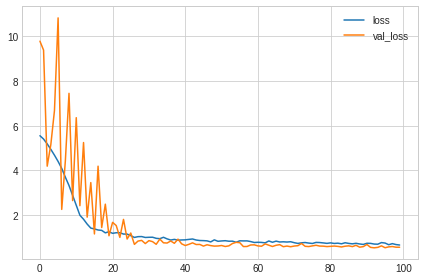

In [3]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=1,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

# EXERCISE

繼續研究 *Spotify* 數據集上的 [**改進預測**](https://www.kaggle.com/kernels/fork/11887342)，看看批次標準化如何幫助處理困難的數據集。